In [101]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset


,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
10,0.061293,0.063490,0.062134,0.063228,0.041940,0.606312,0.057632,0.062393,0.058679,0.060026,...,0.047425,0.048934,0.010677,0.660299,0.045244,0.051930,0.048072,0.047916,0.017841,0.474252
11,0.057632,0.062393,0.058679,0.060026,0.018958,0.491694,0.059011,0.061392,0.058478,0.059141,...,0.048072,0.047916,0.017841,0.474252,0.040196,0.046198,0.041539,0.042476,0.023587,0.462625
12,0.059011,0.061392,0.058478,0.059141,0.014236,0.584718,0.055899,0.059303,0.056266,0.059584,...,0.041539,0.042476,0.023587,0.462625,0.038843,0.044240,0.041417,0.042689,0.008956,0.533223
13,0.055899,0.059303,0.056266,0.059584,0.020237,0.501661,0.052035,0.058531,0.053091,0.055055,...,0.041417,0.042689,0.008956,0.533223,0.041849,0.042116,0.039633,0.041211,0.011421,0.617110
14,0.052035,0.058531,0.053091,0.055055,0.029798,0.486711,0.050046,0.054493,0.052540,0.052428,...,0.039633,0.041211,0.011421,0.617110,0.043458,0.045750,0.043935,0.045847,0.014794,0.589701


In [103]:
dataset = read_csv('./data/VN30.csv', header=0, index_col=0)
dataset

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2012-06-18,510.81,509.62,514.55,508.64,22.57,0.57
2012-06-19,506.67,508.37,510.60,505.02,12.69,-0.81
2012-06-20,508.23,507.23,510.37,504.02,10.66,0.31
2012-06-21,504.71,504.85,507.84,504.52,13.24,-0.69
2012-06-22,500.34,503.97,504.21,499.40,17.35,-0.87
...,...,...,...,...,...,...
2022-12-26,987.77,1032.42,1033.17,987.77,175.23,-4.48
2022-12-27,1007.36,988.87,1015.01,985.67,153.66,1.98
2022-12-28,1013.95,1009.19,1023.24,997.12,123.26,0.65


In [ ]:
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,30] = encoder.fit_transform(values[:,30])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days_lag = 10
n_features = len(dataset.columns)

reframed = series_to_supervised(scaled, n_days_lag, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

In [98]:
# split into train and test sets
n_obs = n_days_lag * n_features

values = reframed.values
n_train_days = int(len(reframed.index) * 0.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, n_obs]
test_X, test_y = test[:, :n_obs], test[:, n_obs]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

2023-05-02 22:02:29.944329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-02 22:02:29.948885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-02 22:02:29.950638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-05-02 22:02:31.061139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-02 22:02:31.071937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-02 22:02:31.081426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

53/53 - 8s - loss: 0.0020 - val_loss: 0.0028 - 8s/epoch - 154ms/step
Epoch 2/50
53/53 - 1s - loss: 0.0048 - val_loss: 0.0013 - 848ms/epoch - 16ms/step
Epoch 3/50
53/53 - 1s - loss: 0.0041 - val_loss: 0.0030 - 812ms/epoch - 15ms/step
Epoch 4/50
53/53 - 1s - loss: 0.0045 - val_loss: 0.0026 - 643ms/epoch - 12ms/step
Epoch 5/50
53/53 - 1s - loss: 0.0043 - val_loss: 0.0109 - 602ms/epoch - 11ms/step
Epoch 6/50
53/53 - 1s - loss: 0.0035 - val_loss: 0.0084 - 598ms/epoch - 11ms/step
Epoch 7/50
53/53 - 1s - loss: 0.0017 - val_loss: 0.0055 - 779ms/epoch - 15ms/step
Epoch 8/50
53/53 - 1s - loss: 7.2739e-04 - val_loss: 0.0034 - 756ms/epoch - 14ms/step
Epoch 9/50
53/53 - 1s - loss: 6.7342e-04 - val_loss: 0.0035 - 785ms/epoch - 15ms/step
Epoch 10/50
53/53 - 1s - loss: 7.1372e-04 - val_loss: 0.0037 - 750ms/epoch - 14ms/step
Epoch 11/50
53/53 - 1s - loss: 7.3385e-04 - val_loss: 0.0038 - 760ms/epoch - 14ms/step
Epoch 12/50
53/53 - 1s - loss: 7.5033e-04 - val_loss: 0.0038 - 885ms/epoch - 17ms/step
Epoch 

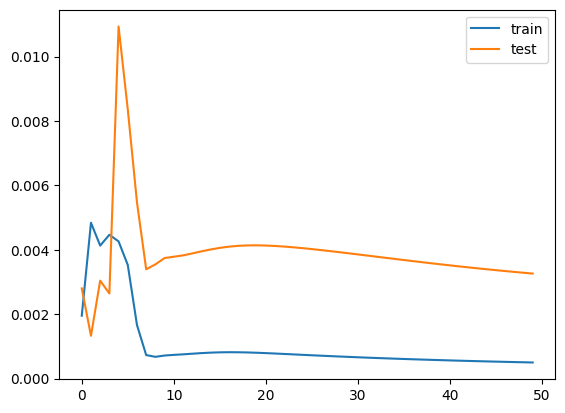

In [92]:
# design network
model = Sequential()

model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.2, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [93]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
def adjust(val, length= 6): return str(val).ljust(length)


In [94]:
# make a prediction
yhat = model.predict(test_X)
test_X_base = test_X.reshape((test_X.shape[0], n_days_lag*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_base[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y,test_X_base[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
print('\nForecast Accuracy of: VN30')
accuracy_prod = forecast_accuracy(inv_yhat, inv_y)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v, 4))

2023-05-02 22:03:21.966733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-02 22:03:21.969031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-02 22:03:21.971756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/17 [==============================] - 1s 6ms/step

Forecast Accuracy of: VN30
mape   :  0.0487
me     :  25.846
mae    :  57.8114
mpe    :  0.0274
rmse   :  74.3962
corr   :  0.9653
minmax :  0.045


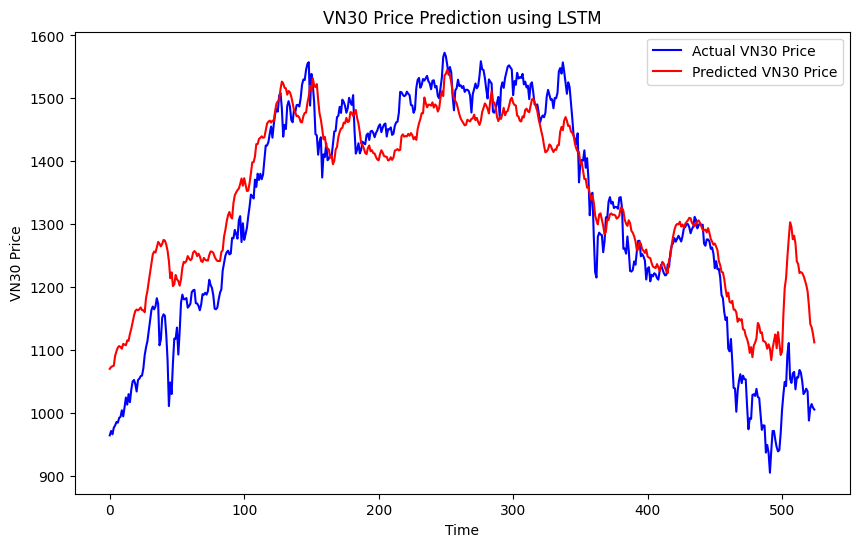

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, len(inv_yhat)), inv_y.flatten(), color='blue', label='Actual VN30 Price')
plt.plot(np.arange(0, len(inv_y)), inv_yhat.flatten(), color='red', label='Predicted VN30 Price')
plt.title('VN30 Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('VN30 Price')
plt.legend()
plt.show()

In [96]:
DataFrame({'pred': inv_yhat, 'true': inv_y})

,pred,true
0,1069.899414,964.159912
1,1072.813721,971.109924
2,1074.098877,965.890076
3,1074.804321,976.349976
4,1090.585083,979.950012
...,...,...
520,1170.594604,987.770020
521,1140.984009,1007.360046
522,1136.169556,1013.950012
523,1125.663452,1008.300049
